In [1]:
import os, sys, time, math
from natsort import natsorted, ns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
from PIL import Image
import glob
import re


from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen

SimpleGVXR 2.0.6 (2023-05-23T20:52:16) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T20:53:11) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
data_path = "4thOCtober_image/"

In [3]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

C:\Users\snn23kfl\project


In [4]:
def average_images(image_paths):
    
    """Average a list of images."""
    # Load the first image to get the shape
    sample_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
    if sample_image is None:
        raise ValueError(f"Failed to load image: {image_paths[0]}")
    
    avg_image = np.zeros_like(sample_image, dtype=float)
    
    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to load image: {path}")
        avg_image += image.astype(float)
    
    avg_image /= len(image_paths)
    
    return cv2.medianBlur(avg_image.astype(np.single), 3)

In [5]:
def flatField(img, white, dark, epsilon=0.0):

    temp_white = np.copy(white)
    temp_img = np.copy(img)
    
    test = white - dark == 0
    temp_white[test] += 1

    if len(img.shape) == 2:
        temp_img[test] += 1
        return (temp_img - dark + epsilon) / (temp_white - dark + epsilon)
    elif len(img.shape) == 3:
        flat = np.zeros(img.shape, dtype=np.single)
        for i, proj in enumerate(temp_img):
            proj[test] += 1
            flat[i] = (proj - dark + epsilon) / (temp_white - dark + epsilon)
        return flat
    else:
        raise IOError("Bad image dimension: " + str(img.shape))

In [6]:
def numerical_sort(file_path):
    # Extract the number from the filename using regex
    number = int(re.search(r'(\d+)', file_path).group(1))
    return number

In [7]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [8]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [9]:
I_raw = []
for fname in raw_image_paths:
    I_raw.append(cv2.imread(fname, 
                           cv2.IMREAD_GRAYSCALE))
I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

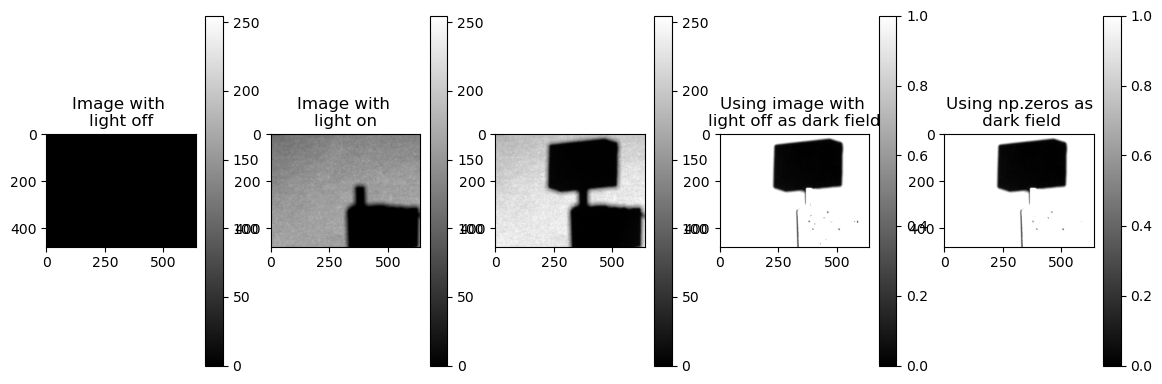

In [10]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [11]:
I_flat = I_flat2

In [12]:
#sod = 43
#sod =47
sod = 48
sdd = 61

In [13]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj = 5
y_obj = 0
z_obj = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj,
    y_obj,
    z_obj,

    alpha_x, 
    alpha_y,
    alpha_z,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [14]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR("simulation1.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


In [15]:
# Load our source properties
json2gvxr.initSourceGeometry("simulation1.json")
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [16]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [17]:
# Load our detector
json2gvxr.initDetector("simulation1.json")
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


In [18]:
# Load our samples
json2gvxr.initSamples("simulation1.json", verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

In [19]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [20]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

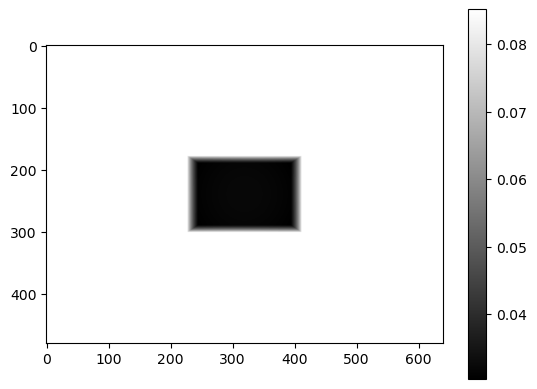

In [21]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [22]:
def getXrayImage(x, take_screenshot=False):
    
    backup = gvxr.getLocalTransformationMatrix("root")

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    gvxr.setSourcePosition(x_src, y_src, z_src, "mm")
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]
    gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

    x_obj = x[6]
    y_obj = x[7]
    z_obj = x[8]

    alpha_x = x[9]
    alpha_y = x[10]
    alpha_z = x[11]

    gvxr.resetSceneTransformation();

    
    
#     gvxr.rotateNode("root", rot_angle, 1, 0, 0)
    
#     gvxr.translateNode("root", x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos, "mm")

    
    
    gvxr.translateNode("root", x_obj, y_obj, z_obj, "mm")
    
    gvxr.rotateNode("root", alpha_x, 1, 0, 0)
    gvxr.rotateNode("root", alpha_y, 0, 1, 0)
    gvxr.rotateNode("root", alpha_z, 0, 0, 1)
    
    gvxr.translateNode("root", -x_obj, -y_obj, -z_obj, "mm")
    
    test_image = np.array(gvxr.computeXRayImage(), dtype=np.single)

    if take_screenshot:
        global screenshot
        gvxr.displayScene()        
        screenshot = gvxr.takeScreenshot()
    
    gvxr.setLocalTransformationMatrix("root", backup)
    
    return test_image / gvxr.getTotalEnergyWithDetectorResponse()

In [23]:
def compare(ref, test):
    return np.abs(ref - test).mean()

ref_image = np.copy(I_flat[0])

# ref_image -= ref_image.mean()
# ref_image /= ref_image.std()

# ref_image -= ref_image.min()
# ref_image /= ref_image.max()

def fitness(x):
    global ref_image

    test_image = getXrayImage(x)

    # std_dev = test_image.std()

    # if std_dev > 1e-6:
    #     test_image -= test_image.mean()
    #     test_image /= std_dev

    #     fitness_value = compare(ref_image, test_image)
    # else:
    #     fitness_value = 10
    fitness_value = compare(ref_image, test_image)
        
    return fitness_value

In [24]:
def displayResult(x):
    global screenshot
    test_image = getXrayImage(x, True)
    
    ref_tmp = np.copy(I_flat[0])
    test_tmp = np.copy(test_image)
    
    ref_tmp -= ref_tmp.mean()
    ref_tmp /= ref_tmp.std()

    test_tmp -= test_tmp.mean()
    test_tmp /= test_tmp.std()

    ZNCC = 100 * (ref_tmp / test_tmp).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    plt.suptitle("ZNCC=" + "{:.4f}".format(ZNCC) + "%")
    axs[0].imshow(screenshot)
    axs[1].imshow(I_flat[0], cmap="gray", vmin=-1, vmax=1)
#   axs[1].imshow(I_flat,cmap="gray", vmin=0, vmax=1)
    axs[2].imshow(test_image,cmap="gray", vmin=-1, vmax=1)
    im = axs[3].imshow((I_flat[0] - test_image),cmap="gray", vmin=-1, vmax=1)

#    im = axs[3].imshow((I_flat - test_image),cmap="gray", vmin=-1, vmax=1)
    cbar = fig.colorbar(im)

#     for ax in axs:
#         ax.set_xlim([100, 600])
#         ax.set_ylim([211, 470])
#    plt.savefig('x_default.jpg', dpi=300, bbox_inches='tight')

    plt.show()    

Overall ZNCC: 22.5236%


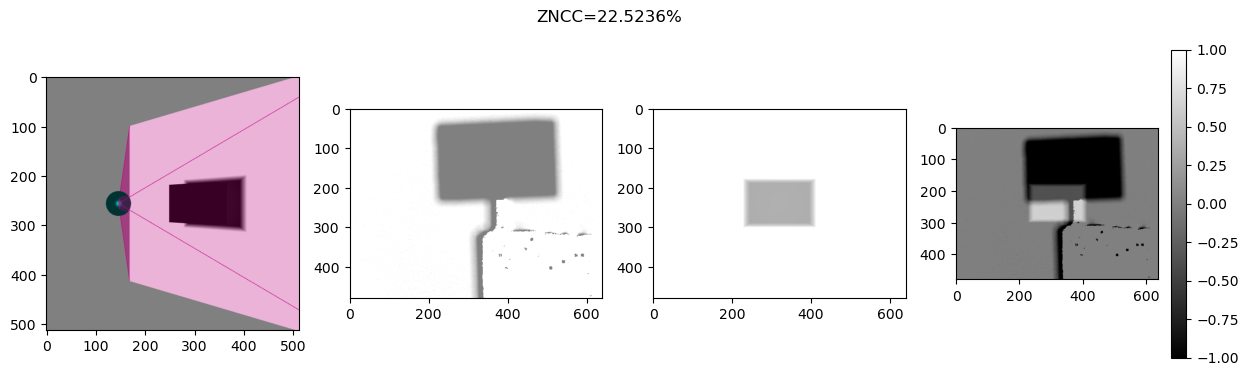

In [25]:
# %matplotlib notebook

displayResult(x_default)

In [26]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((9*[-1000], [-180, -180])), np.hstack((9*[1000], [180, 180]))];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(current_folder + "/x_best1.dat", x_best1)
else:
    x_best1 = np.loadtxt(current_folder + "/x_best1.dat")
    


(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=789963, Thu Oct 19 06:23:02 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 2.180577367544174e-01 1.0e+00 4.89e-01  5e-01  5e-01 0:00.3
    2     22 2.162595838308334e-01 1.2e+00 4.92e-01  5e-01  5e-01 0:00.6
    3     33 2.147208601236343e-01 1.2e+00 5.11e-01  5e-01  5e-01 0:00.8
   14    154 1.787793040275574e-01 2.0e+00 2.27e+00  2e+00  3e+00 0:03.9
   29    319 1.288384497165680e-01 1.9e+00 6.05e+00  5e+00  6e+00 0:07.9
   45    495 1.038492992520332e-01 2.7e+00 2.36e+00  2e+00  3e+00 0:13.3
   61    671 9.918680787086487e-02 4.2e+00 1.62e+00  1e+00  2e+00 0:19.3
   81    891 9.870617836713791e-02 6.8e+00 1.23e+00  8e-01  2e+00 0:26.5
  100   1100 9.742020070552826e-02 9.1e+00 9.55e-01  6e-01  1e+00 0:33.3
  126   1386 9.661255776882172e-02 1.7e+01 6.22e-01  3e-01  8e-01 0:42.6
  154   1694 9.606812894344330e-02 2.8e+01 4.40e-01  2e-01  6e-01 0:52.7
  185   2035 9.599257260560989e-0

In [27]:
print(x_best1)

[   4.53684882    2.3046913    78.0298633    10.35410233  -29.69337453
 -112.02785489   30.66914153   46.49145192   17.75839726   -2.43362456
    0.5318511    -2.52531339]


Overall ZNCC: 98.8370%


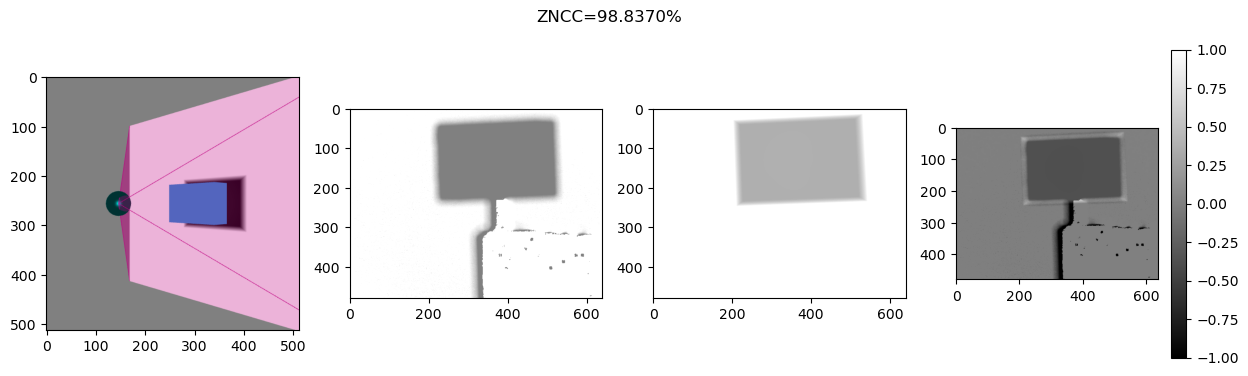

In [28]:
displayResult(x_best1)

In [29]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((9*[-1250], [-180, -180])), np.hstack((9*[1250], [180, 180]))];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.25, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(current_folder + "/x_best2.dat", x_best2)
else:
    x_best2 = np.loadtxt(current_folder + "/x_best2.dat")
    

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=871804, Thu Oct 19 06:24:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 9.459588676691055e-02 1.0e+00 2.31e-01  2e-01  2e-01 0:00.4
    2     22 9.547736495733261e-02 1.2e+00 2.29e-01  2e-01  2e-01 0:00.7
    3     33 9.446344524621964e-02 1.3e+00 2.13e-01  2e-01  2e-01 0:01.1
   12    132 9.473003447055817e-02 1.9e+00 1.65e-01  1e-01  2e-01 0:04.3
   24    264 9.444157034158707e-02 3.0e+00 1.21e-01  9e-02  2e-01 0:08.6
   39    429 9.442109614610672e-02 5.3e+00 1.36e-01  9e-02  2e-01 0:13.8
   57    627 9.436465054750443e-02 7.7e+00 4.69e-02  3e-02  7e-02 0:20.1
   77    847 9.436003118753433e-02 1.5e+01 4.73e-02  2e-02  8e-02 0:27.2
   94   1034 9.435722976922989e-02 2.4e+01 2.74e-02  1e-02  5e-02 0:33.1


In [30]:
print(x_best2)

[   5.12821843    2.51895007   77.87961698    9.76473592  -29.94480772
 -112.64347438   30.79258834   46.01240301   17.55223673   -2.58288789
    0.94406306   -2.53053991]


Overall ZNCC: 91.1286%


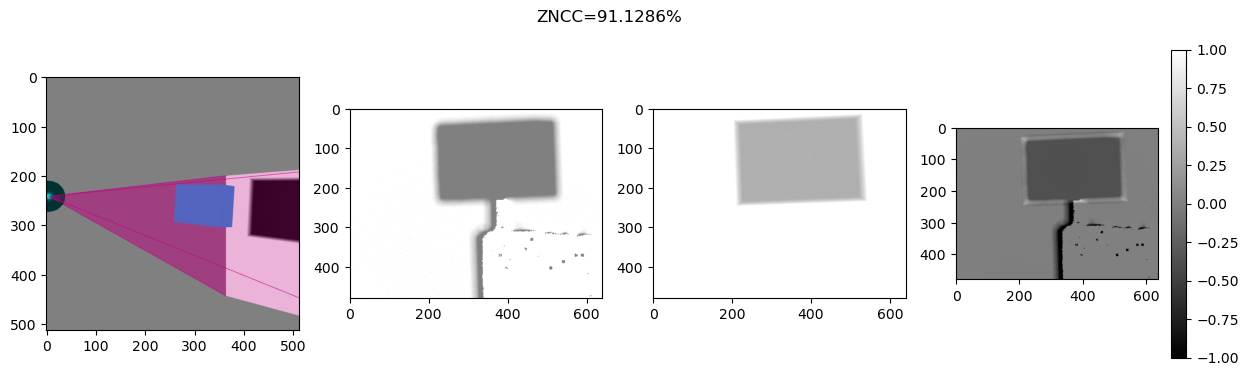

In [31]:
displayResult(x_best2)

In [32]:
import cma
from tifffile import imread, imwrite


In [33]:
# Load images into I_raw
I_raw = []
for fname in raw_image_paths:
    I_raw.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
I_raw = np.array(I_raw, dtype=np.single)

In [34]:
# Calculate the total number of projections and angular step
total_nb_projs = I_raw.shape[0]
angular_span = 360
angular_step = angular_span / total_nb_projs

In [35]:
I_raw = []
for fname in raw_image_paths:
    I_raw.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
I_raw = np.array(I_raw, dtype=np.single)


In [36]:
ref_image = np.copy(I_flat[0])


In [37]:
import cma
from tifffile import imread, imwrite


In [38]:
raw_image_0_path = [path for path in raw_image_paths if "_0.tiff" in path][0]
raw_image_90_path = [path for path in raw_image_paths if "_90.tiff" in path][0]



In [39]:
I_raw_0 = cv2.imread(raw_image_0_path, cv2.IMREAD_GRAYSCALE)
I_raw_90 = cv2.imread(raw_image_90_path, cv2.IMREAD_GRAYSCALE)


In [40]:
I_flat_0 = flatField(I_raw_0, I_white, I_dark)
I_flat_90 = flatField(I_raw_90, I_white, I_dark)


In [41]:
#ref_image = np.copy(I_flat_0)


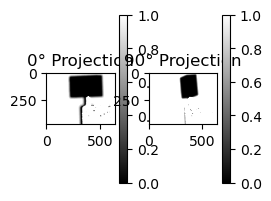

In [42]:
plt.subplot(2, 5, 3)
plt.title("0° Projection")
plt.imshow(I_flat_0, cmap="gray", vmin=0, vmax=1)
plt.colorbar()

plt.subplot(2, 5, 4)
plt.title("90° Projection")
plt.imshow(I_flat_90, cmap="gray", vmin=0, vmax=1)
plt.colorbar()


In [43]:
#def getXrayImage(x, take_screenshot=False):
def getXrayImage(x, angle=0, take_screenshot=False ):   
    backup = gvxr.getLocalTransformationMatrix("root")

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    gvxr.setSourcePosition(x_src, y_src, z_src, "mm")
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]
    gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

    x_obj = x[6]
    y_obj = x[7]
    z_obj = x[8]

    alpha_x = x[9]
    alpha_y = x[10]
    alpha_z = x[11]

    gvxr.resetSceneTransformation();

#gvxr.rotateNode("root", angle, 0, 0, 1)
    
#     gvxr.rotateNode("root", rot_angle, 1, 0, 0)
    
#     gvxr.translateNode("root", x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos, "mm")

    
    
    gvxr.translateNode("root", x_obj, y_obj, z_obj, "mm")
    
    gvxr.rotateNode("root", alpha_x, 1, 0, 0)
    gvxr.rotateNode("root", alpha_y, 0, 1, 0)
    gvxr.rotateNode("root", alpha_z, 0, 0, 1)
    
    gvxr.translateNode("root", -x_obj, -y_obj, -z_obj, "mm")
    
    test_image = np.array(gvxr.computeXRayImage(), dtype=np.single)

    if take_screenshot:
        global screenshot
        gvxr.displayScene()        
        screenshot = gvxr.takeScreenshot()
    
    gvxr.setLocalTransformationMatrix("root", backup)
    
    return test_image / gvxr.getTotalEnergyWithDetectorResponse()

In [44]:
# Load images into I_raw
I_raw = []
for fname in raw_image_paths:
    I_raw.append(cv2.imread(fname, cv2.IMREAD_GRAYSCALE))
I_raw = np.array(I_raw, dtype=np.single)



In [45]:
# def setNumberOfProjections(n):
#     global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

#     nb_projs_in_fitness = n
    
#     ref_images = []
#     fitness_angles = []
#     fitness_fnames = []

#     for i in range(nb_projs_in_fitness):
#         index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
#         print(i, angles[index], fnames_images[index])
#         ref_images.append(imread(fnames_images[index]))
#         fitness_angles.append(angles[index])
#         fitness_fnames.append(fnames_images[index])

#     ref_images = np.array(ref_images, dtype=np.single)
#     ref_images -= ref_images.mean()
#     ref_images /= ref_images.std()

#     fitness_angles = np.array(fitness_angles, dtype=np.single)

#     #test_images = np.zeros(ref_images.shape, dtype=np.single)
#     test_images = np.zeros((n, ref_images.shape[1], ref_images.shape[2]), dtype=np.single) 
#     #test_images = np.zeros(ref_images.shape, dtype=np.single)
#     crop_ref_images = ref_images[:, 211:470, 100:600]
#     crop_ref_images -= crop_ref_images.mean()
#     crop_ref_images /= crop_ref_images.std()

def setNumberOfProjections(n):
    global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

    nb_projs_in_fitness = n
    
    ref_images = []
    fitness_angles = []
    fitness_fnames = []

    for i in range(nb_projs_in_fitness):
        index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
        print(i, angles[index], fnames_images[index])
        image = imread(fnames_images[index])
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = image[:, :, 0]  # Convert to grayscale if necessary
        ref_images.append(image)
        fitness_angles.append(angles[index])
        fitness_fnames.append(fnames_images[index])

    ref_images = np.array(ref_images, dtype=np.single)
    ref_images -= ref_images.mean()
    ref_images /= ref_images.std()

    fitness_angles = np.array(fitness_angles, dtype=np.single)

    test_images = np.zeros(ref_images.shape, dtype=np.single)
    
    crop_ref_images = ref_images[:, 211:470, 100:600]
    crop_ref_images -= crop_ref_images.mean()
    crop_ref_images /= crop_ref_images.std()


In [46]:
# def setNumberOfProjections(n):
#     global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

#     nb_projs_in_fitness = n
    
#     ref_images = []
#     fitness_angles = []
#     fitness_fnames = []

#     # Calculate the indices for 0 and 90 degrees
#     index_0_deg = int(0 / angular_step)
#     index_90_deg = int(90 / angular_step)

#     # Select the images for 0 and 90 degrees
#     indices = [index_0_deg, index_90_deg]

#     for index in indices:
#         print(index, angles[index], fnames_images[index])
#         ref_images.append(imread(fnames_images[index]))
#         fitness_angles.append(angles[index])
#         fitness_fnames.append(fnames_images[index])

#     ref_images = np.array(ref_images, dtype=np.single)
#     ref_images -= ref_images.mean()
#     ref_images /= ref_images.std()

#     fitness_angles = np.array(fitness_angles, dtype=np.single)

#     test_images = np.zeros(ref_images.shape, dtype=np.single)
    
#     crop_ref_images = ref_images[:, 211:470, 100:600]
#     crop_ref_images -= crop_ref_images.mean()
#     crop_ref_images /= crop_ref_images.std()


In [47]:
# Calculate the total number of projections and angular step
total_nb_projs = I_flat1.shape[0]
angular_span = 360
angular_step = angular_span / total_nb_projs

fnames_images = []
angles = []

for i in range(total_nb_projs):
    angles.append(i * angular_step)
    corrected_image = I_flat1[i]
    
    # Save corrected image
    corrected_image_path = current_folder + "/4thOctober_image/corrected_images/corrected_image_" + str(i) + ".tiff"
    imwrite(corrected_image_path, corrected_image)
    
    fnames_images.append(corrected_image_path)


In [48]:
def displayResult(x):
    transform(x)
    
    ZNCC = 100 * (crop_ref_images * crop_test_images).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    for i, (angle, fname) in enumerate(zip(fitness_angles, fitness_fnames)):
        
        ref = np.copy(crop_ref_images[i])
        test = np.copy(crop_test_images[i])

        ref -= ref.mean()
        ref /= ref.std()
        
        test -= test.mean()
        test /= test.std()
        
        ZNCC = 100 * (ref * test).mean()

        offset=1.5
        # imwrite(current_folder + "/test_" + str(i) + "tif", test_images[i])
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        plt.suptitle(fname + ", ZNCC=" + "{:.4f}".format(ZNCC) + "%")
        axs[0].imshow(ref_images[i],cmap="gray", vmin=-offset, vmax=offset)
        axs[1].imshow(test_images[i],cmap="gray", vmin=-offset, vmax=offset)
        # axs[2].imshow(np.abs(ref_images[i] - test_images[i]),cmap="gray")
        im = axs[2].imshow((ref_images[i] - test_images[i]),cmap="gray", vmin=-offset, vmax=offset)
        cbar = fig.colorbar(im)
        
        for ax in axs:
            ax.set_xlim([100, 600])
            ax.set_ylim([211, 470])

        fig = plt.figure(figsize=(10, 4))
        plt.plot(crop_ref_images[i][crop_ref_images.shape[1] // 2, :], label="Experimental")
        plt.plot(crop_test_images[i][crop_ref_images.shape[1] // 2, :], label="Simulated")
        plt.legend()
        plt.show()    

In [49]:
# # Calculate the indices for 0 and 90 degrees
# index_0_deg = int(0 / angular_step
# index_90_deg = int(90 / angular_step)

# # Extract the images for 0 and 90 degrees
# img_0_deg = I_raw[index_0_deg]
# img_90_deg = I_raw[index_90_deg]

# # Apply flat field correction
# I_flat1 = flatField(I_raw, I_white, I_dark)
# I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# # Clamp pixel values
# I_flat1[I_flat1 < 0] = 0
# I_flat2[I_flat2 < 0] = 0

# I_flat1[I_flat1 > 1] = 1
# I_flat2[I_flat2 > 1] = 1


In [58]:
setNumberOfProjections(2)

0 0.0 C:\Users\snn23kfl\project/4thOctober_image/corrected_images/corrected_image_0.tiff
1 87.37864077669903 C:\Users\snn23kfl\project/4thOctober_image/corrected_images/corrected_image_25.tiff


In [60]:
# def transform(x):
    
#     global test_images, fitness_angles, crop_test_images
#     backup = gvxr.getLocalTransformationMatrix("root")
    
#     for i, angle in enumerate(fitness_angles):
    
#         # Rotate
#         gvxr.resetSceneTransformation();
#         gvxr.translateNode("root", x[0], x[1], x[2], "mm")
#         gvxr.rotateNode("root", angle, 0, 0, 1)        
#         gvxr.translateNode("root", x[3], x[4], x[5], "mm")


#         # Simulate
#         #test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)  
#         #test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)
#         test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)
#         gvxr.setLocalTransformationMatrix("root", backup)

#     test_images -= test_images.mean()
#     test_images /= test_images.std()

#     crop_test_images = test_images[:, 211:470, 100:600]
#     crop_test_images -= crop_test_images.mean()
#     crop_test_images /= crop_test_images.std()    

def transform(x):
    global test_images, fitness_angles, crop_test_images
    backup = gvxr.getLocalTransformationMatrix("root")
    
    for i, angle in enumerate(fitness_angles):
    
        # Rotate
        gvxr.resetSceneTransformation();
        gvxr.translateNode("root", x[0], x[1], x[2], "mm")
        gvxr.rotateNode("root", angle, 0, 0, 1)        
        gvxr.translateNode("root", x[3], x[4], x[5], "mm")

        # Simulate
        test_image = np.array(gvxr.computeXRayImage(), dtype=np.single)
        if len(test_image.shape) == 3 and test_image.shape[2] == 3:
            test_image = test_image[:, :, 0]  # Convert to grayscale if necessary
        test_images[i] = test_image
        
        gvxr.setLocalTransformationMatrix("root", backup)

    test_images -= test_images.mean()
    test_images /= test_images.std()

    crop_test_images = test_images[:, 211:470, 100:600]
    crop_test_images -= crop_test_images.mean()
    crop_test_images /= crop_test_images.std()


In [61]:
def fitness(x):
    
    global ref_images, test_image, fitness_angles, nb_projs_in_fitness, crop_ref_images
    
    transform(x)
        
    return np.abs(crop_ref_images - crop_test_images).mean()
    # return np.abs(ref_images - test_images).sum() / nb_projs_in_fitness
    # return 1.0 - (ref_images * test_images).mean()

Overall ZNCC: 49.6398%


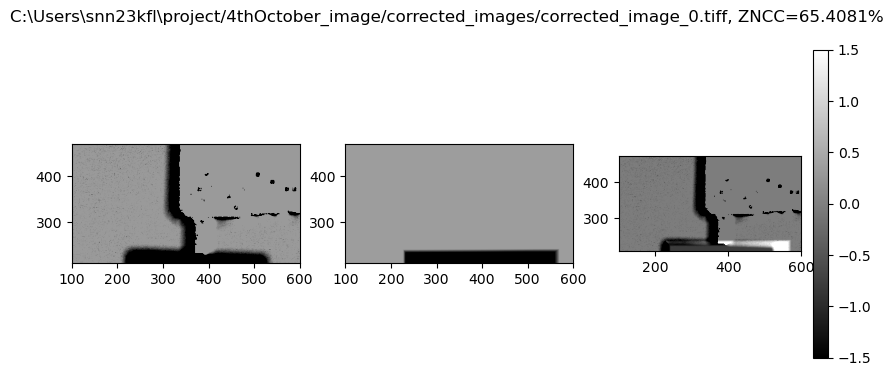

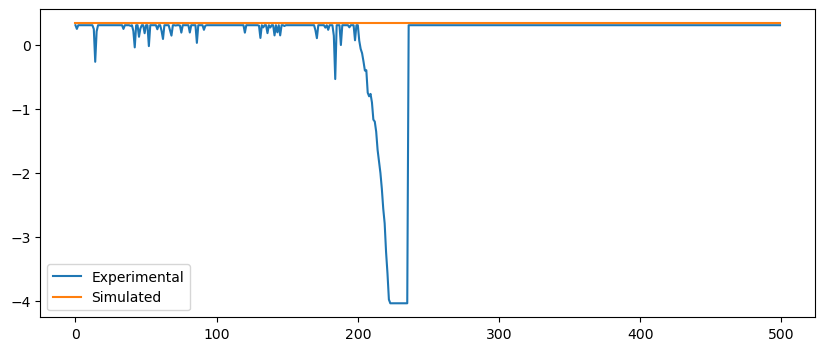

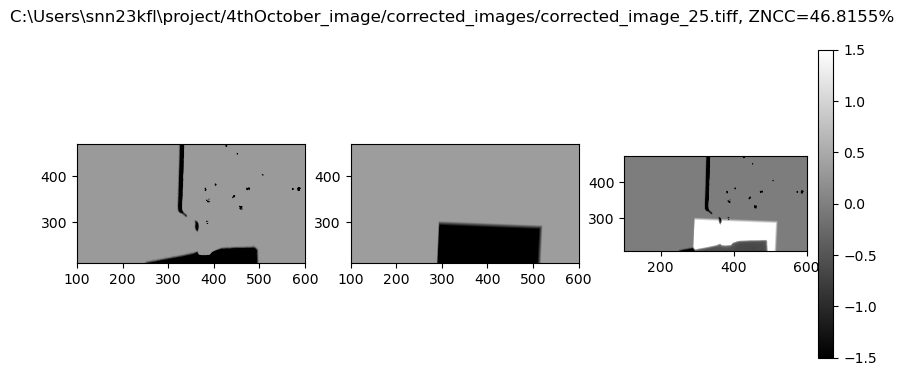

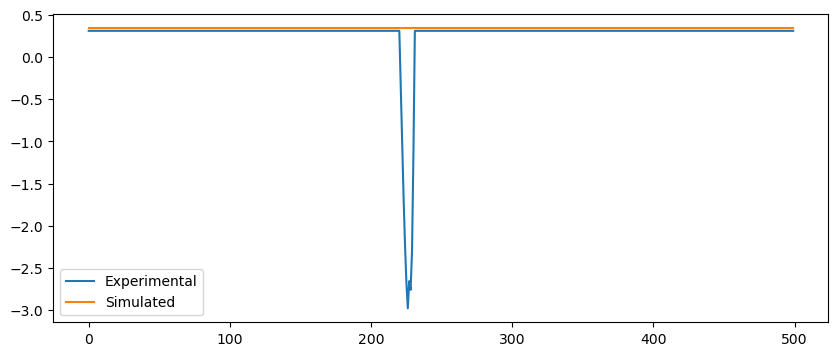

In [53]:
displayResult(6*[0.0])

In [64]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [6*[-2], 6*[2]];

if not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy([6*[0.0]], 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(current_folder + "/x_best1.dat", x_best1)
else:
    x_best1 = np.loadtxt(current_folder + "/x_best1.dat")

In [65]:
print(x_best1)

[   4.53684882    2.3046913    78.0298633    10.35410233  -29.69337453
 -112.02785489   30.66914153   46.49145192   17.75839726   -2.43362456
    0.5318511    -2.52531339]


Overall ZNCC: 3.6137%


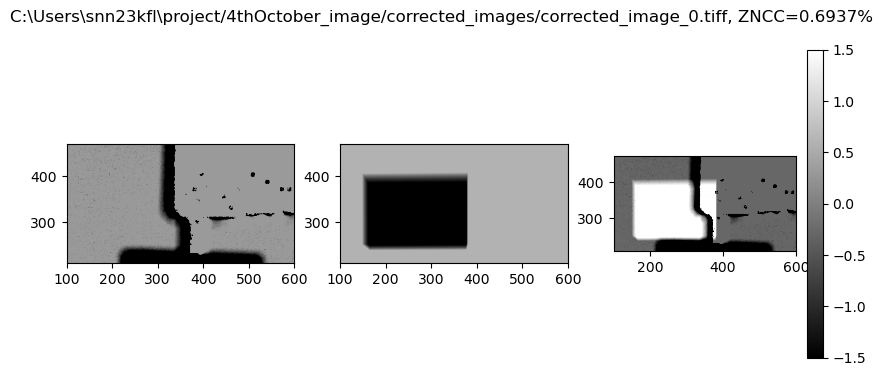

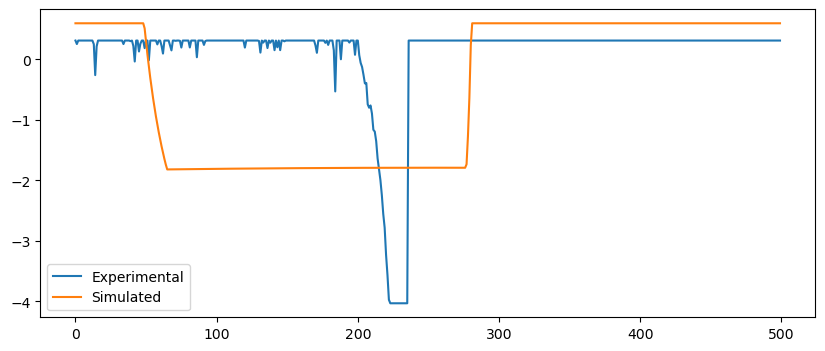

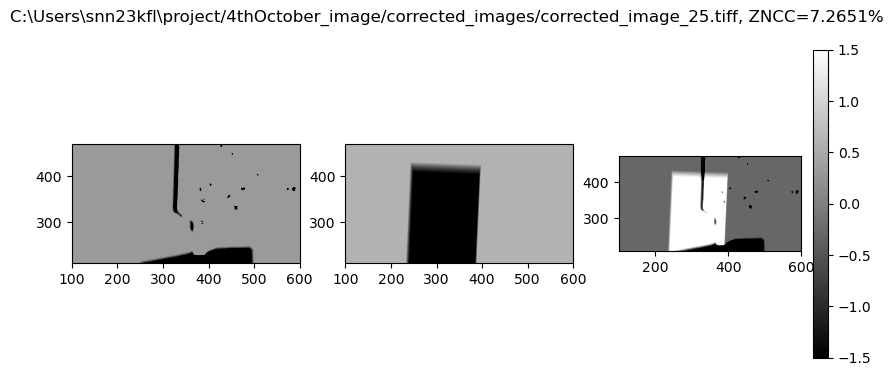

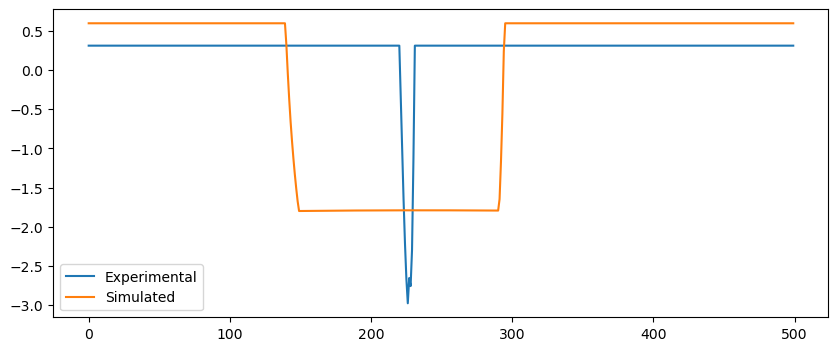

In [66]:
displayResult(x_best1)

In [68]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-3);
opts['tolx'] = 1e-3;
opts['bounds'] = [6*[-2], 6*[2]];

if not os.path.exists(current_folder + "/x_best2.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy([6*[0.0]], 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(current_folder + "/x_best2.dat", x_best2)
else:
    x_best12 = np.loadtxt(current_folder + "/x_best2.dat")

In [69]:
print(x_best2)

[   5.12821843    2.51895007   77.87961698    9.76473592  -29.94480772
 -112.64347438   30.79258834   46.01240301   17.55223673   -2.58288789
    0.94406306   -2.53053991]


Overall ZNCC: 4.2512%


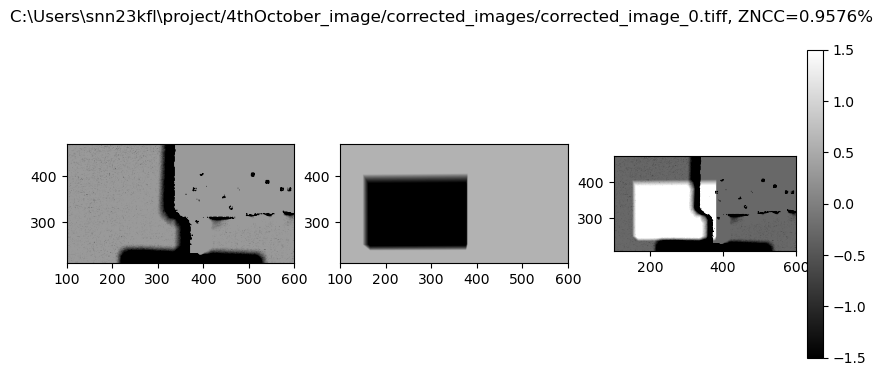

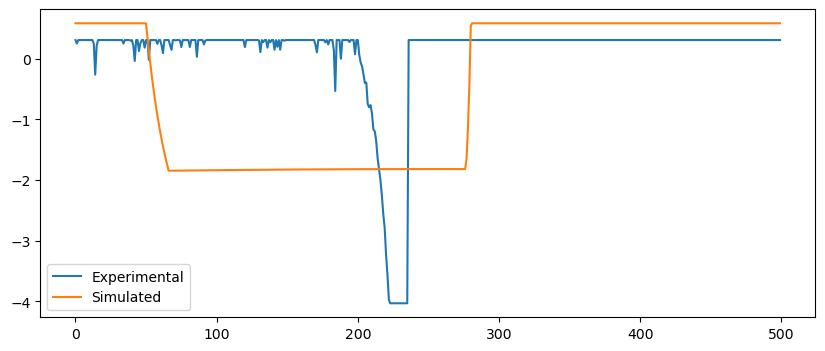

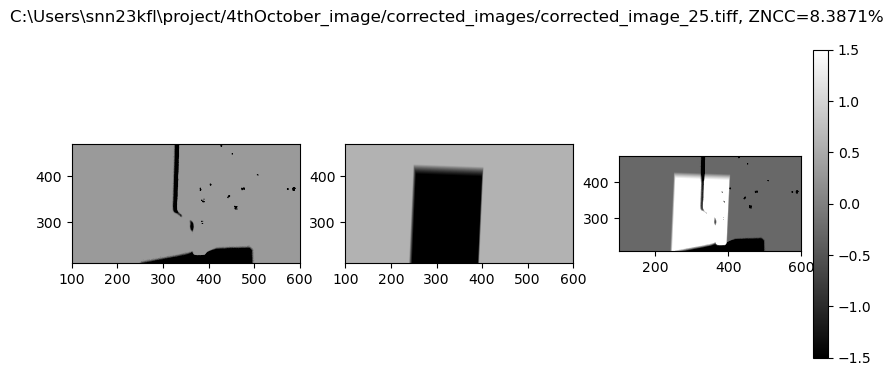

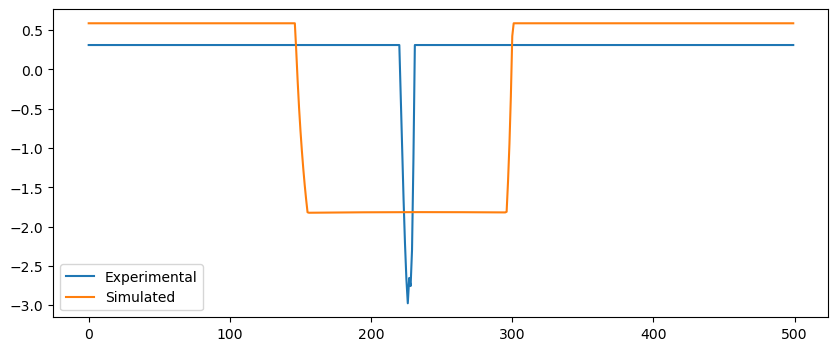

In [70]:
displayResult(x_best2)

In [54]:
def fitness(x):
    global ref_image_0_deg, ref_image_90_deg

    test_image_0_deg = getXrayImage(x, angle=0)
    test_image_90_deg = getXrayImage(x, angle=90)

    fitness_value_0_deg = compare(ref_image_0_deg, test_image_0_deg)
    fitness_value_90_deg = compare(ref_image_90_deg, test_image_90_deg)
        
    return fitness_value_0_deg + fitness_value_90_deg


In [55]:
ref_image_0_deg = I_flat1[index_0_deg]
ref_image_90_deg = I_flat1[index_90_deg]


NameError: name 'index_0_deg' is not defined

In [ ]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((9*[-1250], [-180, -180])), np.hstack((9*[1250], [180, 180]))];

# Define initial guess for the parameters
x_initial = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Start optimization
if True:  # not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time()
    es = cma.CMAEvolutionStrategy(x_initial, 0.25, opts)
    es.optimize(fitness)
    elapsed_time = time.time() - start_time


    x_best = es.result.xbest
    np.savetxt(current_folder + "/x_best.dat", x_best)
else:
   x_best = np.loadtxt(current_folder + "/x_best")

In [ ]:
# Display the result
displayResult(x_best)

In [ ]:
# it worked from here without applying flatfield
# total_nb_projs = 103
# angular_span = 360
# angular_step = 360 / total_nb_projs

# fnames_images = []
# angles = []

# for i in range(total_nb_projs):
#     angles.append(i*angular_step)
#     fnames_images.append(current_folder + "/4thOctober_image/raw_images/raw_image_" + str(i) + ".tiff")    

In [ ]:
fitness_angles = [0, 90]

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
img_0_deg = imread(fnames_images[0])
img_90_deg = imread(fnames_images[int(90/angular_step)])

crop_ref_images = np.array([img_0_deg[211:470, 100:600], img_90_deg[211:470, 100:600]])

In [ ]:
# Convert the cropped reference images to grayscale
crop_ref_images = rgb2gray(crop_ref_images)

In [ ]:
def transform(x):
    global fitness_angles
    global test_images, fitness_angles, crop_test_images
    
    
    # Dynamically determine the image size
    sample_image = np.array(gvxr.computeXRayImage())
    height, width = sample_image.shape
    
    # Dynamically allocate space for test_images
    num_angles = len(fitness_angles)
    test_images = np.zeros((num_angles, height, width))
    
    
    
    
    backup = gvxr.getLocalTransformationMatrix("root")
    
    for i, angle in enumerate(fitness_angles):
    
        # Rotate
        gvxr.resetSceneTransformation();
        gvxr.translateNode("root", x[0], x[1], x[2], "mm")
        gvxr.rotateNode("root", angle, 0, 0, 1)        
        gvxr.translateNode("root", x[3], x[4], x[5], "mm")


        # Simulate
        #ttest_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)
        test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)  
        
        gvxr.setLocalTransformationMatrix("root", backup)

    test_images -= test_images.mean()
    
    test_images /= test_images.std()

    crop_test_images = test_images[:, 211:470, 100:600]
    crop_test_images -= crop_test_images.mean()
    crop_test_images /= crop_test_images.std()    

In [ ]:
def fitness(x):
    global fitness_angles, crop_ref_images, crop_test_images
    transform(x)        
    return np.abs(crop_ref_images - crop_test_images).mean()


In [ ]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((9*[-1250], [-180, -180])), np.hstack((9*[1250], [180, 180]))];

if True:#not os.path.exists(current_folder + "/x_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.25, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(current_folder + "/x_best2.dat", x_best2)
else:
    x_best2 = np.loadtxt(current_folder + "/x_best2.dat")
    

In [ ]:
# Display the image at 0 degrees
img_0_deg = imread(fnames_images[0])
plt.imshow(img_0_deg, cmap="gray")
plt.title("Image at 0 degrees")
plt.colorbar()
plt.show()

# Display the image at 90 degrees
img_90_deg = imread(fnames_images[1])
plt.imshow(img_90_deg, cmap="gray")
plt.title("Image at 90 degrees")
plt.colorbar()
plt.show()






In [ ]:
def setNumberOfProjections(n):
    global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

    nb_projs_in_fitness = n
    
    ref_images = []
    fitness_angles = []
    fitness_fnames = []

    for i in range(nb_projs_in_fitness):
        index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
        print(i, angles[index], fnames_images[index])
        ref_images.append(imread(fnames_images[index]))
        fitness_angles.append(angles[index])
        fitness_fnames.append(fnames_images[index])

    ref_images = np.array(ref_images, dtype=np.single)
    ref_images -= ref_images.mean()
    ref_images /= ref_images.std()

    fitness_angles = np.array(fitness_angles, dtype=np.single)

    #test_images = np.zeros(ref_images.shape, dtype=np.single)
    test_images = np.zeros((n, 480, 640), dtype=np.single)
    
    crop_ref_images = ref_images[:, 211:470, 100:600]
    crop_ref_images -= crop_ref_images.mean()
    crop_ref_images /= crop_ref_images.std()

In [ ]:
# def setNumberOfProjections(n):
#     global nb_projs_in_fitness, ref_images, crop_ref_images, fitness_angles, fitness_fnames, test_images

#     nb_projs_in_fitness = n
#     total_nb_projs = 103
#     angles = [0, 90]
#     fnames_images = ["image_at_0_degrees.tiff", "image_at_90_degrees.tiff"]
    
#     ref_images = []
#     fitness_angles = []
#     fitness_fnames = []
    
#     for i in range(nb_projs_in_fitness):
#         print(i, angles[i], fnames_images[i])
#         ref_images.append(cv2.imread(fnames_images[i], cv2.IMREAD_GRAYSCALE))

    
# #     for i in range(nb_projs_in_fitness):
# #         index = int(i / nb_projs_in_fitness * total_nb_projs / 2)
# #         print(i, angles[index], fnames_images[index])
# #         #ref_images.append(imread(fnames_images[index]))
# #         ref_images.append(cv2.imread(fnames_images[index], cv2.IMREAD_GRAYSCALE))
#         fitness_angles.append(angles[i])
#         fitness_fnames.append(fnames_images[i])

#     ref_images = np.array(ref_images, dtype=np.single)
#     ref_images -= ref_images.mean()
#     ref_images /= ref_images.std()

#     fitness_angles = np.array(fitness_angles, dtype=np.single)

#     test_images = np.zeros(ref_images.shape, dtype=np.single)
    
#     crop_ref_images = ref_images[:, 211:470, 100:600]
#     crop_ref_images -= crop_ref_images.mean()
#     crop_ref_images /= crop_ref_images.std()

In [ ]:
def displayResult(x):
    transform(x)
    
    ZNCC = 100 * (crop_ref_images * crop_test_images).mean()
    print("Overall ZNCC:", "{:.4f}".format(ZNCC) + "%")
    
    for i, (angle, fname) in enumerate(zip(fitness_angles, fitness_fnames)):
        
        ref = np.copy(crop_ref_images[i])
        test = np.copy(crop_test_images[i])

        ref -= ref.mean()
        ref /= ref.std()
        
        test -= test.mean()
        test /= test.std()
        
        ZNCC = 100 * (ref * test).mean()

        offset=1.5
        # imwrite(current_folder + "/test_" + str(i) + "tif", test_images[i])
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        plt.suptitle(fname + ", ZNCC=" + "{:.4f}".format(ZNCC) + "%")
        axs[0].imshow(ref_images[i],cmap="gray", vmin=-offset, vmax=offset)
        axs[1].imshow(test_images[i],cmap="gray", vmin=-offset, vmax=offset)
        # axs[2].imshow(np.abs(ref_images[i] - test_images[i]),cmap="gray")
        im = axs[2].imshow((ref_images[i] - test_images[i]),cmap="gray", vmin=-offset, vmax=offset)
        cbar = fig.colorbar(im)
        
        for ax in axs:
            ax.set_xlim([100, 600])
            ax.set_ylim([211, 470])

        fig = plt.figure(figsize=(10, 4))
        plt.plot(crop_ref_images[i][crop_ref_images.shape[1] // 2, :], label="Experimental")
        plt.plot(crop_test_images[i][crop_ref_images.shape[1] // 2, :], label="Simulated")
        plt.legend()
        plt.show()    

In [ ]:
setNumberOfProjections(2)

In [ ]:
def transform(x):
    
    global test_images, fitness_angles, crop_test_images
    backup = gvxr.getLocalTransformationMatrix("root")
    
    for i, angle in enumerate(fitness_angles):
    
        # Rotate
        gvxr.resetSceneTransformation();
        gvxr.translateNode("root", x[0], x[1], x[2], "mm")
        gvxr.rotateNode("root", angle, 0, 0, 1)        
        gvxr.translateNode("root", x[3], x[4], x[5], "mm")


        # Simulate
        #ttest_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)
        test_images[i] = np.array(gvxr.computeXRayImage(), dtype=np.single)  
        
        gvxr.setLocalTransformationMatrix("root", backup)

    test_images -= test_images.mean()
    
    test_images /= test_images.std()

    crop_test_images = test_images[:, 211:470, 100:600]
    crop_test_images -= crop_test_images.mean()
    crop_test_images /= crop_test_images.std()    

In [ ]:
def fitness(x):
    
    global ref_images, test_image, fitness_angles, nb_projs_in_fitness, crop_ref_images
    
    transform(x)
        
    return np.abs(crop_ref_images - crop_test_images).mean()
    # return np.abs(ref_images - test_images).sum() / nb_projs_in_fitness
    # return 1.0 - (ref_images * test_images).mean()

In [ ]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-2);
opts['tolx'] = 1e-2;
opts['bounds'] = [6*[-2], 6*[2]];

if not os.path.exists(current_folder + "/bx_best1.dat"):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy([6*[0.0]], 0.5, opts);
    es.optimize(fitness);
    elapsed_time = time.time() - start_time

    bx_best1 = es.result.xbest
    np.savetxt(current_folder + "/bx_best1.dat", x_best1)
else:
    bx_best1 = np.loadtxt(current_folder + "/bx_best1.dat")

In [ ]:
displayResult(bx_best1)

In [ ]:
# def fitness(x):
#     # Simulate images for 0° and 90°
#     test_image_0 = getXrayImage(x, 0)
#     test_image_90 = getXrayImage(x, 90)

#     # Compute the difference for 0°
#     diff_0 = compare(I_flat_0, test_image_0)

#     # Compute the difference for 90°
#     diff_90 = compare(I_flat_90, test_image_90)

#     # Return the average difference
#     return (diff_0 + diff_90) / 2


In [ ]:
# plt.figure(figsize=(14,10))

# plt.subplot(2, 5, 1)
# plt.title("0° Projection")
# plt.imshow(I_flat_0, cmap="gray", vmin=0, vmax=1)
# plt.colorbar()

# plt.subplot(2, 5, 2)
# plt.title("90° Projection")
# plt.imshow(I_flat_90, cmap="gray", vmin=0, vmax=1)
# plt.colorbar()

In [ ]:
# def displayResult(x):
#     global screenshot_0, screenshot_90

#     # Simulate images for 0° and 90°
#     test_image_0 = getXrayImage(x, 0)
#     test_image_90 = getXrayImage(x, 90)

    

#     # Normalize the real and simulated images for 0°
#     ref_tmp_0 = np.copy(I_flat_0)
#     test_tmp_0 = np.copy(test_image_0)
#     ref_tmp_0 -= ref_tmp_0.mean()
#     ref_tmp_0 /= ref_tmp_0.std()
#     test_tmp_0 -= test_tmp_0.mean()
#     test_tmp_0 /= test_tmp_0.std()

#     # Normalize the real and simulated images for 90°
#     ref_tmp_90 = np.copy(I_flat_90)
#     test_tmp_90 = np.copy(test_image_90)
#     ref_tmp_90 -= ref_tmp_90.mean()
#     ref_tmp_90 /= ref_tmp_90.std()
#     test_tmp_90 -= test_tmp_90.mean()
#     test_tmp_90 /= test_tmp_90.std()

#     # Compute ZNCC for both angles
#     ZNCC_0 = 100 * (ref_tmp_0 / test_tmp_0).mean()
#     ZNCC_90 = 100 * (ref_tmp_90 / test_tmp_90).mean()

#     # Display the results
#     fig, axs = plt.subplots(2, 4, figsize=(20, 8))
#     plt.suptitle(f"ZNCC_0 = {ZNCC_0:.4f}% | ZNCC_90 = {ZNCC_90:.4f}%")

#     axs[0, 0].imshow(screenshot_0)
#     axs[0, 1].imshow(I_flat_0, cmap="gray", vmin=-1, vmax=1)
#     axs[0, 2].imshow(test_tmp_0, cmap="gray", vmin=-1, vmax=1)
#     axs[0, 3].imshow(ref_tmp_0 - test_tmp_0, cmap="gray", vmin=-1, vmax=1)

#     axs[1, 0].imshow(screenshot_90)
#     axs[1, 1].imshow(I_flat_90, cmap="gray", vmin=-1, vmax=1)
#     axs[1, 2].imshow(test_tmp_90, cmap="gray", vmin=-1, vmax=1)
#     axs[1, 3].imshow(ref_tmp_90 - test_tmp_90, cmap="gray", vmin=-1, vmax=1)

#     plt.show()



In [ ]:
# opts = cma.CMAOptions()
# opts.set('tolfun', 1e-5)
# opts['tolx'] = 1e-5
# opts['bounds'] = [np.hstack((9*[-1250], [-180, -180])), np.hstack((9*[1250], [180, 180]))]

# if True:#not os.path.exists(current_folder + "/x_best1.dat"):
#     start_time = time.time()
#     es = cma.CMAEvolutionStrategy(x_default, 0.25, opts)
#     es.optimize(fitness)
#     elapsed_time = time.time() - start_time

#     cx_best1 = es.result.xbest
#     np.savetxt(current_folder + "/cx_best1.dat", x_best2)
# else:
#     cx_best1 = np.loadtxt(current_folder + "/cx_best1.dat")


In [ ]:
# displayResult(cx_best1)